In [1]:
# Importing libraries
import scipy as scipy
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns
from scipy.stats import norm

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [2]:

df = pd.read_csv(r'C:\Users\ssayc\HandsOnRec\data\filteredData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1932 non-null   int64  
 1   fullname             1932 non-null   object 
 2   analyzed             1932 non-null   object 
 3   cloneurl             1932 non-null   object 
 4   ncommits             1932 non-null   int64  
 5   created_at           1932 non-null   object 
 6   default_branch       1932 non-null   object 
 7   description          1919 non-null   object 
 8   errormsg             0 non-null      float64
 9   error_commits_count  1932 non-null   int64  
 10  filtered             1932 non-null   object 
 11  filterinfo           0 non-null      float64
 12  fork                 1932 non-null   object 
 13  nforks               1932 non-null   int64  
 14  homepage             1337 non-null   object 
 15  language             1932 non-null   o

In [3]:
df_sub = df[["fullname", "description", "created_at", "ncommits", "nforks", "nauthors", "nfiles" , "open_issues", "mainlanguage", "tf"]]

In [4]:
df_sub

,fullname,description,created_at,ncommits,nforks,nauthors,nfiles,open_issues,mainlanguage,tf
0,Bearded-Hen/Android-Bootstrap,"Bootstrap style widgets for Android, with Glyp...",2013-11-01 15:36:17,326,1337,25,142,16,Java,1
1,mediaelement/mediaelement,HTML5 <audio> or <video> player with support f...,2010-07-28 02:32:56,4315,1137,242,225,2,JavaScript,1
2,redis-store/redis-store,"Namespaced Rack::Session, Rack::Cache, I18n an...",2009-04-11 14:15:41,565,303,66,28,5,Ruby,1
3,magento/magento2,All Submissions you make to Magento Inc. (“Mag...,2011-11-30 15:30:13,53219,3335,538,27791,2491,PHP,1
4,spinnaker/spinnaker,"Spinnaker is an open source, multi-cloud conti...",2014-07-02 19:02:36,1390,460,67,406,174,Python,2
...,...,...,...,...,...,...,...,...,...,...
1927,mlpack/mlpack,mlpack: a scalable C++ machine learning librar...,2014-12-17 18:16:59,16348,572,125,1067,84,C++,2
1928,cleanflight/cleanflight,Clean-code version of the baseflight flight co...,2013-03-27 23:49:19,8612,1737,245,2784,14,C,3
1929,awesome-print/awesome_print,Pretty print your Ruby objects with style -- i...,2010-04-03 04:45:43,436,233,54,99,73,Ruby,3
1930,trogdoro/xiki,A shell console with GUI features,2008-06-05 01:03:11,1085,205,11,636,112,Ruby,1


In [5]:
df_sub.describe()

,ncommits,nforks,nauthors,nfiles,open_issues,tf
count,1932.000000,1932.000000,1932.000000,1932.000000,1932.000000,1932.000000
mean,5512.519151,1157.253106,165.318323,1278.552277,176.706004,1.988095
std,25415.733623,2113.814316,584.098263,4404.114362,325.036151,2.107018
min,0.000000,32.000000,1.000000,3.000000,0.000000,1.000000
25%,554.750000,303.000000,35.000000,87.000000,26.750000,1.000000
50%,1253.500000,581.000000,72.000000,227.500000,74.000000,1.000000
75%,3604.000000,1204.000000,147.000000,774.250000,186.250000,2.000000
max,678122.000000,51209.000000,14970.000000,67804.000000,4467.000000,26.000000


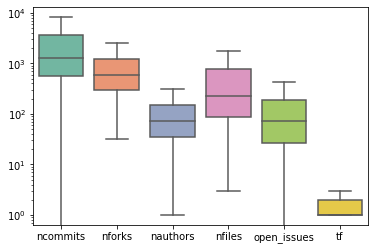

In [6]:
# new numeric only dataframe to visualize data distribution
df_stats = df_sub[['ncommits', 'nforks', 'nauthors', 'nfiles', 'open_issues', 'tf']]


# Lets create box plots for  distribution of quantitative data
g = sns.boxplot(data=df_stats, orient="v", palette="Set2", showfliers=False)
g.set_yscale('log')

#v = sns.violinplot(data=df_stats, orient="v", showfliers=False)


There are 129952 words in the combination of all project descriptions


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

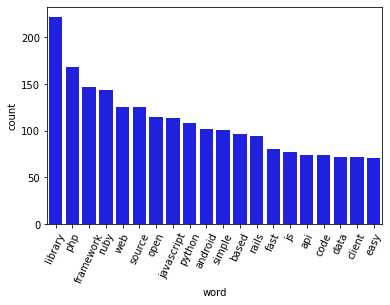

In [7]:
# create corpus of descriptions 
corpus = " ".join(review for review in df_sub.description.astype(str))
print ("There are {} words in the combination of all project descriptions".format(len(corpus)))
corpus=[corpus]

# function to get unigrams 
def get_unigrams(corpus, n=None):
    vector = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_o_words = vector.transform(corpus)
    sum_words = bag_o_words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x:x[1], reverse=True)
    return words_freq[:n]

common_words = get_unigrams(corpus, 20)

# plot corpus dataframe 
df2 = pd.DataFrame(common_words, columns = ['word', 'count'])
df2.groupby('word').sum()['count'].sort_values(ascending=False)

plot = sns.barplot(x='word', y='count', data=df2, color="blue")

plt.xticks(rotation=65)


In [8]:
df_sub['nauthors'].describe()

count     1932.000000
mean       165.318323
std        584.098263
min          1.000000
25%         35.000000
50%         72.000000
75%        147.000000
max      14970.000000
Name: nauthors, dtype: float64

In [9]:
# Content Based Recommendation System 
# input will be top match from result of knowledge based system
# output will be top 10 matches 

# define tf-idf object and remove stopwords
tfidf = TfidfVectorizer(stop_words='english')
                        
# fill empty descriptions 
df_sub['description'] = df_sub['description'].fillna('')
                        
# Construct tfidf matrix 
tfidf_matrix = tfidf.fit_transform(df_sub['description'])

# Compute cosine-similarity matrix 
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Reverse mapping of indicies and project names
indices = pd.Series(df_sub.index, index=df_sub['fullname']).drop_duplicates()

# Function that takes in project name as input and gives recommendations 
def content_recommender(name, cosine_sim=cosine_sim, df=df_sub, indices=indices):
    # Obtain the index of the project that matches the name
    idx = indices[name]

    # Get the pairwsie similarity scores of all projects with that project
    # And convert it into a list of tuples
    sim_scores = list(enumerate(cosine_sim[idx]))
   
    # Sort the projects based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the most similar project 
    sim_scores = sim_scores[1:6]

    # Get the project indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar projects
    return df.iloc[movie_indices]

<ipython-input-9-2c1c64189131>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['description'] = df_sub['description'].fillna('')


In [10]:
# Knowledge Based Recommendation System 
# input our data frame of github projects

def query_user(language, community, resp, df=df_sub):
    
    # language query
    #print("Enter your favorite coding language:")
    #language = input()
    
    # community query 
    #print("On a scale of 1-3, how would you rate your experience with OSS? 1 being newbie, 3 being an OSS veteran.")
    #community = int(input())
    
     # willingness to help - here were going to put stuff like are you willing to help and yes or no it will be sorted by tf otherwise forks only 
    #print("Would you be willing to help an at risk project? Y or N")
    #resp = input()
    
    if (community == 3):
        min_auth = 0
        max_auth = 50
    elif (community == 2):
        min_auth = 50
        max_auth = 150
    else: 
        min_auth = 100
        max_auth = 1500000
        
    
    # scale is 1 = 100-max, 2 = 50-100, 3 = 1-50
    df_final = df.copy() 
    df_final = df_final[(df_final['mainlanguage'] == language)]
    df_final = df_final[df_final['nauthors'] >= min_auth]
    df_final = df_final[df_final['nauthors'] <= max_auth]
    
    # Sort based on nforks, we want to focus on smaller projects 
    # if resp is True then sort based on tf 
    if (resp == 'N'):
        df_final = df_final.sort_values(['nforks'], ascending=True)
    elif (resp == 'Y'):
        df_final = df_final.sort_values(['tf', 'nforks'], ascending=[True, True])
    #print(df_final)
    # Grab top 10 matches from our query 
    result = df_final.iloc[0:10]
    
    return result
    

In [11]:
def OS_REC(language, community, resp): 
    # store results from knowledge rec
    knowledge = query_user(language=language, community=community, resp=resp)
    
    # set up author guidelines for satisfaction calculation 
    # ****FIXME ***** we want to add condition to determine probability distribution 
    if (community == 3):
        mina = 0
        maxa = 50
        mean = 7
    elif (community == 2):
        mina = 50
        maxa = 150
        mean = 5
    else: 
        mina = 100
        maxa = 100000000
        mean = 3
    word_matches = []
    for i in range(10):
        # get content based rec for each query result
        rec = content_recommender(knowledge['fullname'].iloc[i])
        top_match = rec.iloc[0]
        # save the top match 
        word_matches.append(top_match)
    # new df for our final set
    word_matches = pd.DataFrame(word_matches)
    
    final_df = pd.concat([word_matches, knowledge])
    # rank based on forks, prioritize smaller projects
    hello = final_df.sort_values(['nforks'], ascending=True)
    results = hello.head(10)
    
    # Get outcome satisfaction 
    scores = norm.rvs(size=10, loc=mean, scale=2)
    satisfaction = scores.mean()
        # Now we are going to assign a random 1-10 value from our predetermined distribution. 
        # Assign each result a "rating" and then average for the final satisfaction 
    return satisfaction

In [12]:
# Create User Profiles 
users = pd.read_csv(r'C:\Users\ssayc\HandsOnRec\data\user_profiles.csv')
users

,Lang,Ex,Resp
0,Python,1,Y
1,Ruby,2,Y
2,Java,3,N
3,C++,3,N
4,PHP,1,N
5,JavaScript,2,Y
6,C,2,Y
7,Ruby,1,Y
8,PHP,3,Y
9,Python,2,N


In [13]:
# generate satisfaction column 
new_col = []
for i in range(len(users)):
    lang = users.iloc[i]['Lang']
    ex = users.iloc[i]['Ex']
    resp = users.iloc[i]['Resp']
    sat = OS_REC(lang, ex, resp)
    new_col.append(sat)
users['sat_actual'] = new_col


In [14]:
users

,Lang,Ex,Resp,sat_actual
0,Python,1,Y,3.870484
1,Ruby,2,Y,4.507256
2,Java,3,N,7.458781
3,C++,3,N,6.654252
4,PHP,1,N,2.476634
5,JavaScript,2,Y,4.655045
6,C,2,Y,5.298238
7,Ruby,1,Y,3.509355
8,PHP,3,Y,7.189222
9,Python,2,N,5.201383


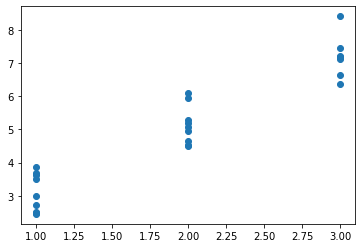

In [88]:
# training data 
train = users.iloc[:25]
x_train = train['Ex']
y_train = train['sat_actual']

plt.scatter(x_train, y_train)

In [89]:
mymodel = np.poly1d(np.polyfit(x_train, y_train, 3))

c:\users\ssayc\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
from sklearn.metrics import r2_score
print(r2_score(y_train, mymodel(x_train)))

0.8939910961332123


In [91]:
hi = mymodel(1)
hi

3.0895612556778285

In [92]:
# testing set
test = users.iloc[25:]
sat_pred = []
for i in range(len(test)):
    ex = test.iloc[i]['Ex']
    prediction = mymodel(ex)
    sat_pred.append(prediction)
test['sat_pred'] = sat_pred

<ipython-input-92-3d2e3820940b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['sat_pred'] = sat_pred


In [93]:
test

,Lang,Ex,Resp,sat_actual,sat_pred
25,C,2,N,4.247064,5.145002
26,Ruby,1,N,3.070007,3.089561
27,Python,3,Y,8.445934,7.201231
28,C++,2,Y,4.774825,5.145002
29,PHP,1,N,3.477103,3.089561
30,Ruby,3,Y,7.556866,7.201231
31,Python,3,N,6.127147,7.201231
32,Java,2,Y,5.051948,5.145002
33,JavaScript,1,N,1.829350,3.089561
34,PHP,2,Y,5.046691,5.145002


In [94]:


values = test[['sat_actual', 'sat_pred']]


# Accuracy metrics 
mae = sk.metrics.mean_absolute_error(values['sat_actual'], values['sat_pred'])
mse = sk.metrics.mean_squared_error(values['sat_actual'], values['sat_pred'])
rmse = sk.metrics.mean_squared_error(values['sat_actual'], values['sat_pred'], squared=False)

print('MAE:', mae, 'MSE:', mse, 'RMSE:', rmse) 



MAE: 0.5286241474161434 MSE: 0.45220339123536313 RMSE: 0.6724606986548457


In [95]:
actual = values['sat_actual']
predict = values['sat_pred']
actual

25    4.247064
26    3.070007
27    8.445934
28    4.774825
29    3.477103
30    7.556866
31    6.127147
32    5.051948
33    1.829350
34    5.046691
35    6.966443
36    2.579303
37    4.407900
38    7.036375
39    8.147604
40    2.792500
41    3.117150
42    5.051593
43    5.023581
44    6.663537
45    2.885287
46    4.136221
47    3.509460
48    5.892302
49    2.287599
Name: sat_actual, dtype: float64

In [48]:

# Decision accuracy metrics 
# F1 Score
#f1 = sk.metrics.f1_score(actuals, predict)
# recall
r = sk.metrics.recall_score(actual, predict, average='macro')
# precision 
#p = sk.metrics.precision_score(actual, predict, average='macro')

print("f1:", f1, "r:", r, "p:", p)

ValueError: continuous is not supported

In [96]:
# change df to an array 

predictions = []
actuals = []
for i in range(len(predict)):
    predictions.append(predict.iloc[i])
    # actual values need to be binary for ROC curve
for i in range(len(actual)):
    if (actual.iloc[i] >= 5):
        actuals.append(1)
    else:
        actuals.append(0)
actuals

[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]

In [97]:
fpr, tpr, thresholds = sk.metrics.roc_curve(actuals, predictions)

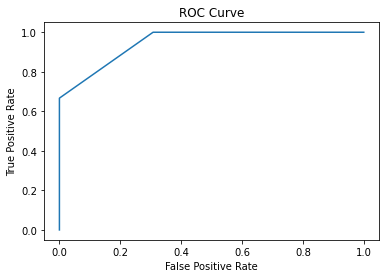

In [98]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()